## Building a DCGAN from Scratch

The first order of the day is to build the generator and the discriminator.


In [3]:
import torch
import torch.nn as nn


In [4]:
z = torch.rand(50,1,100)

Here we build the DCGAN generator from the LSUN generator

In [5]:
class DCGAN_generator (nn.Module):
    def __init__(self):
        super().__init__()
        # Determining the batch size
        

        self.projection = nn.Linear(100,16384)
        self.conv_1 = nn.Sequential(nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2,padding=0),nn.BatchNorm2d(512),nn.ReLU())
        self.conv_2 = nn.Sequential(nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2,padding=0),nn.BatchNorm2d(256),nn.ReLU())
        self.conv_3 = nn.Sequential(nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2,padding=0),nn.BatchNorm2d(128),nn.ReLU())
        self.conv_4 = nn.Sequential(nn.ConvTranspose2d(in_channels=128,out_channels=3,kernel_size=2,stride=2,padding=0),nn.Tanh())
     
        


    
    def forward(self, x):
        batch_size = x.shape[0]
    
        x = self.projection(x)
        print(batch_size)
        x = x.view(batch_size,1024,4,4)
       
        

        x = self.conv_1(x)
        
        x = self.conv_2(x)
        x = self.conv_3(x) 
        x = self.conv_4(x)
        

        return x   


In [9]:
model = DCGAN_generator()
output = model(z)



50


Also did the LSUN discriminator

In [17]:
class DCGAN_discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.batch_size = z.shape[0]
        
        self.conv_1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=128,kernel_size=2,stride=2),nn.LeakyReLU())
        self.conv_2 = nn.Sequential(nn.Conv2d(in_channels=128,out_channels=256,kernel_size=2,stride=2),nn.BatchNorm2d(256),nn.LeakyReLU())
        self.conv_3 = nn.Sequential(nn.Conv2d(in_channels=256,out_channels=512,kernel_size=2,stride=2),nn.BatchNorm2d(512),nn.LeakyReLU())
        self.conv_4 = nn.Sequential(nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=2,stride=2),nn.BatchNorm2d(1024),nn.LeakyReLU())
        self.flatten = nn.Flatten(0,3)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        
        
        batch_size = x.shape[0]
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.flatten(x)
        fc1 = nn.Linear(16384*batch_size,1*batch_size)
        x = fc1(x)
        x = self.sigmoid(x)
        

        return x
        


In [18]:
class DCGAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.generated_output = DCGAN_generator()
        self.discriminated_output = DCGAN_discriminator()
        

    def forward(self,x):
       x = self.generated_output(x)
       x = self.discriminated_output(x)

       return x





In [21]:
model = DCGAN()
output = model(z)
print(output)


50
tensor([0.6027, 0.5093, 0.3538, 0.4037, 0.5335, 0.3847, 0.4312, 0.3787, 0.6091,
        0.5991, 0.5118, 0.5350, 0.6527, 0.5490, 0.4705, 0.4580, 0.6830, 0.4741,
        0.5182, 0.4739, 0.5289, 0.6656, 0.5451, 0.5775, 0.4839, 0.4346, 0.5622,
        0.5612, 0.5819, 0.3181, 0.5404, 0.6167, 0.5860, 0.3534, 0.3475, 0.4017,
        0.3443, 0.5928, 0.4716, 0.4553, 0.7663, 0.5555, 0.3707, 0.5733, 0.4193,
        0.5408, 0.4884, 0.5362, 0.4940, 0.5089], grad_fn=<SigmoidBackward0>)


In [25]:
import torch.optim as optim
generator = DCGAN_generator()
discriminator = DCGAN_discriminator()
gan = DCGAN()
criterion_generator = nn.CrossEntropyLoss()
criterion_discriminator = nn.CrossEntropyLoss()
criterion_GAN = nn.CrossEntropyLoss()
optimizer_generator = optim.Adam(model.parameters(), lr=0.001)
optimizer_discriminator = optim.Adam(model.parameters(), lr=0.0001)
optimizer_gan = optim.Adagrad(model.parameters(), lr=0.0001)


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


# Load the MNIST dataset

# Define the transformations to resize the images to 224x224
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST training and testing datasets with the defined transformations
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

torch.Size([64, 1, 64, 64])


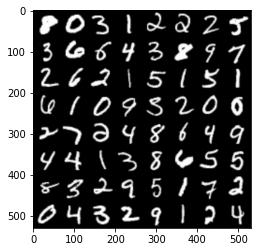

In [35]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

# Print 64 random images from the test dataset
images, _ = next(iter(test_loader))
image_grid = make_grid(images, nrow=8, normalize=True)

plt.imshow(image_grid.permute(1, 2, 0))
plt.show()

In [76]:
rgb_image = torch.stack([images,images,images],dim=1)
rgb_image = torch.squeeze(rgb_image,dim=2)
for i, (images, labels) in enumerate(test_loader):
    output = discriminator(rgb_image)
    loss = criterion_discriminator(output.float(),labels.float())
    print(loss)
    loss.backward()

    output = generator(torch.rand(64,1,100))
    disc_output =discriminator(output) 
    loss_fake = criterion_generator(disc_output.float(),labels.float()) 
    loss_total = loss + loss_fake
    loss_fake.backward()

    



tensor(1095.2256, grad_fn=<DivBackward1>)
64
tensor(945.9000, grad_fn=<DivBackward1>)
64
tensor(1169.5714, grad_fn=<DivBackward1>)
64
tensor(1263.0867, grad_fn=<DivBackward1>)
64
tensor(1130.2772, grad_fn=<DivBackward1>)
64
tensor(1062.5298, grad_fn=<DivBackward1>)
64


KeyboardInterrupt: 